In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples

from optimizers.lfbo.lfbo_joint import LFBO_Joint
from optimizers.lfbo.lfbo_joint_rand import LFBO_JointRand
from optimizers.lfbo.lfbo_mlp import LFBO_MLP

tkwargs = {"device": "cpu:0", "dtype": torch.double}

In [3]:
def forrester(x, noise_level=.2):
    f = np.sin(3*x) + x**2 - 0.7*x + np.random.normal(0, noise_level, x.shape)
    return f

bounds = torch.tensor([[-1.], [2.]], **tkwargs)

In [4]:
x_dense = torch.linspace(-1, 2, 512, **tkwargs).reshape(-1, 1)
y_dense = forrester(x_dense, noise_level=0)

In [5]:
num_obs = 32
x_obs = draw_sobol_samples(bounds=bounds, n=num_obs, q=1, seed=123).squeeze(-2)
y_obs = forrester(x_obs, noise_level=0.2).squeeze()

In [6]:
lfbo_joint_rand = LFBO_JointRand(input_dim=1, output_dim=1, **tkwargs)
lfbo_joint = LFBO_Joint(input_dim=1, output_dim=1, **tkwargs)
lfbo_mlp = LFBO_MLP(input_dim=1, **tkwargs)

In [7]:
lfbo_joint.fit(x_obs, y_obs, S=1000)

In [8]:
lfbo_joint_rand.fit(x_obs, y_obs, S=10000)

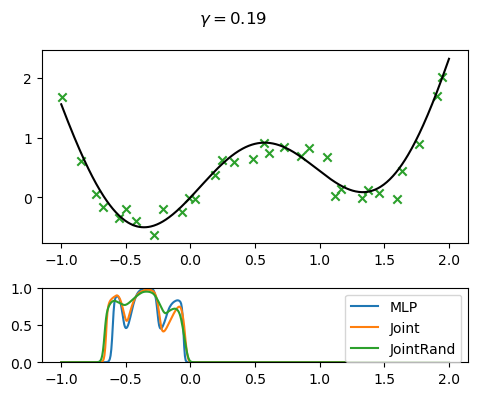

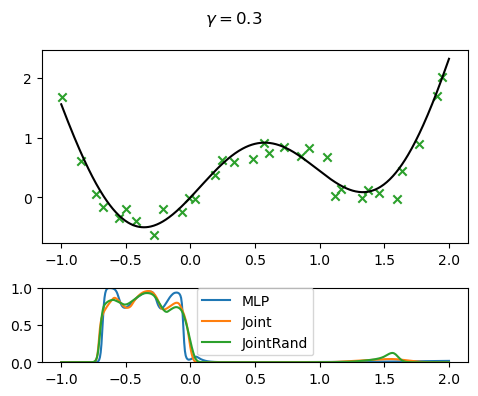

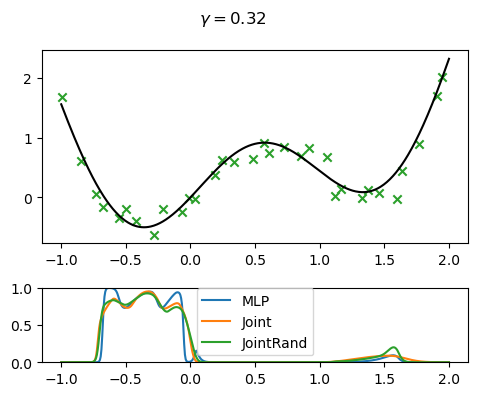

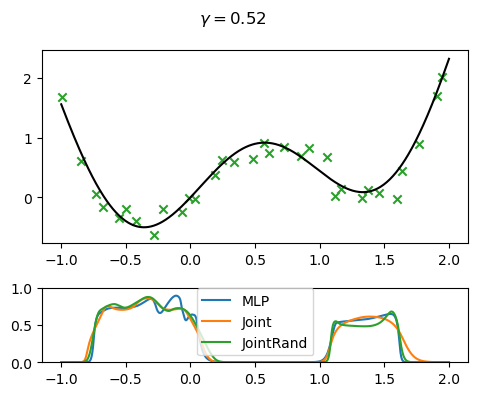

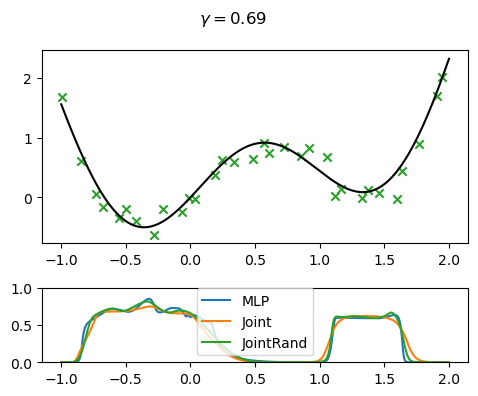

In [9]:
gammas, _ = torch.sort(torch.rand(5, **tkwargs))

for gamma in gammas:
    fig = plt.figure(figsize=(5, 4))
    ax_func = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax_func.plot(x_dense, y_dense, color='k', label="objective function")
    ax_func.scatter(x_obs, y_obs, marker='x', color='tab:green', label="observations")

    ax_lfbo = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=ax_func)

    lfbo_mlp.fit(x_obs, y_obs, gamma=gamma, S=1000)
    acf_mlp = lfbo_mlp.predict(x_dense)
    acf_joint = lfbo_joint.predict(x_dense, gamma=gamma)
    acf_joint_rand = lfbo_joint_rand.predict(x_dense, gamma=gamma)

    ax_lfbo.plot(
        x_dense,
        acf_mlp,
        label="MLP",
    )
    ax_lfbo.plot(
        x_dense,
        acf_joint,
        label="Joint",
    )
    ax_lfbo.plot(
        x_dense,
        acf_joint_rand,
        label="JointRand",
    )
    ax_lfbo.set_ylim(0., 1.)
    ax_lfbo.legend()
    fig.suptitle(rf'$\gamma = {gamma:.02}$')
    plt.tight_layout()
    plt.show()

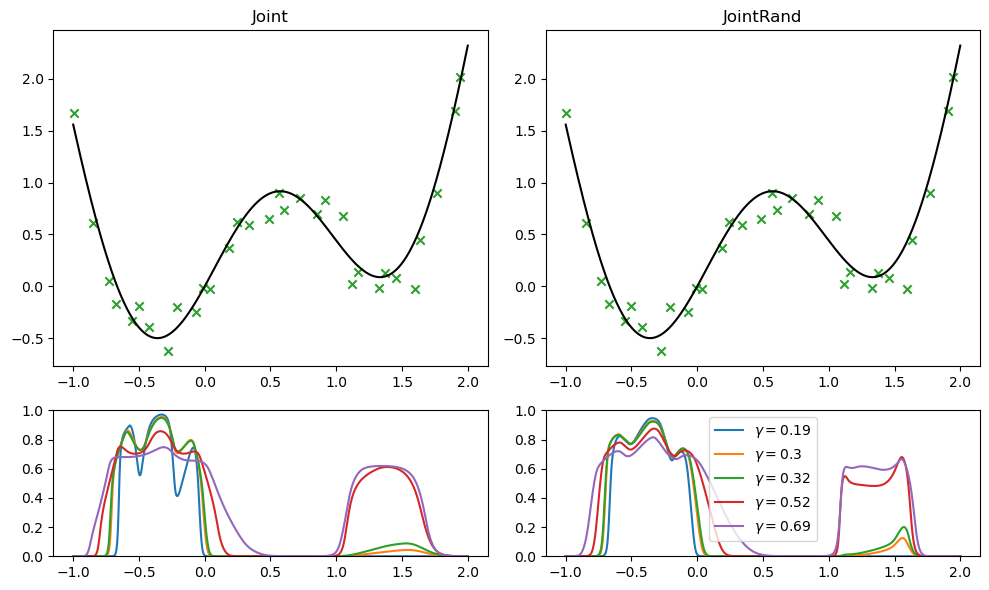

In [17]:
fig = plt.figure(figsize=(10, 6))
ax_joint = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax_joint.plot(x_dense, y_dense, color='k', label="objective function")
ax_joint.scatter(x_obs, y_obs, marker='x', color='tab:green', label="observations")
ax_joint.set_title('Joint')

ax_joint_rand = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
ax_joint_rand.plot(x_dense, y_dense, color='k', label="objective function")
ax_joint_rand.scatter(x_obs, y_obs, marker='x', color='tab:green', label="observations")
ax_joint_rand.set_title('JointRand')

ax_joint_aq = plt.subplot2grid((3, 2), (2, 0), rowspan=1, sharex=ax_joint)
ax_joint_rand_aq = plt.subplot2grid((3, 2), (2, 1), rowspan=1, sharex=ax_joint)

for gamma in gammas:
    acf_joint = lfbo_joint.predict(x_dense, gamma=gamma)
    acf_joint_rand = lfbo_joint_rand.predict(x_dense, gamma=gamma)
    ax_joint_aq.plot(
        x_dense,
        acf_joint,
        label=rf"$\gamma = {gamma:.02}$",
    )
    ax_joint_rand_aq.plot(
        x_dense,
        acf_joint_rand,
        label=rf"$\gamma = {gamma:.02}$",
    )
ax_joint_aq.set_ylim(0., 1.)
ax_joint_rand_aq.set_ylim(0., 1.)
plt.legend()
plt.tight_layout()
plt.show()